In [1]:
# All imports 
import pandas as pd 
from scripts.data_extraction import download_file
from scripts.data_processing import clean_and_transform,process_all_files
from scripts.data_load import load_to_sqlite
import sqlite3
from datetime import datetime,date,time
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import warnings
import os
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_theme(style="whitegrid")

## Data Download from 2019-2024 

In [ ]:


# # Base URL and file pattern
base_url = "https://d37ci6vzurychx.cloudfront.net/trip-data/"
start_year = 2019
end_year = 2024
current_year = date.today().year
current_month = date.today().month
years = range(start_year, end_year+1)  
months = range(1, 13)  
current_year_months=range(1,current_month-2)
current_year_months=range(1,10) 

file_format = "yellow_tripdata_{year}-{month:02d}.parquet"

for year in years:
    if year == current_year:
        for month in current_year_months:
            file_name = file_format.format(year=year, month=month)
            file_url = base_url + file_name
            download_file(file_url)
    else:
        for month in months:
            file_name = file_format.format(year=year, month=month)
            file_url = base_url + file_name
            download_file(file_url)


## Data Cleaning,Processing and load to sqlite database



In [ ]:
# Because data size is big  handling files one by one and directly loading the data to sqlite data base for further analysis 
# It is very to handle this amount of data in local config at once

start_year = 2019
end_year = 2024
current_year = date.today().year
current_month = date.today().month
years = range(start_year, end_year+1)  
months = range(1, 13)  
current_year_months=range(1,current_month-2)
DB_FILE = "sql/nyc_taxi_data.db"

for year in years:
    if year==current_year:
        for month in current_year_months:
            file_name = f"yellow_tripdata_{year}-{month:02d}.parquet"
            df =process_all_files("data/"+file_name,"Processed_Data/"+file_name)
            load_to_sqlite(DB_FILE, df)
            print(file_name,"Sqlite data load Complete")
    else:
        for month in months:
            file_name = f"yellow_tripdata_{year}-{month:02d}.parquet"
            df=process_all_files("data/"+file_name,"Processed_Data/"+file_name)
            load_to_sqlite(DB_FILE, df)
            print(file_name,"Sqlite data load Complete")

data/yellow_tripdata_2019-01.parquet procesed
Data successfully loaded into sql/nyc_taxi_data.db
yellow_tripdata_2019-01.parquet Sqlite data load Complete
data/yellow_tripdata_2019-02.parquet procesed
Data successfully loaded into sql/nyc_taxi_data.db
yellow_tripdata_2019-02.parquet Sqlite data load Complete
data/yellow_tripdata_2019-03.parquet procesed
Data successfully loaded into sql/nyc_taxi_data.db
yellow_tripdata_2019-03.parquet Sqlite data load Complete
data/yellow_tripdata_2019-04.parquet procesed
Data successfully loaded into sql/nyc_taxi_data.db
yellow_tripdata_2019-04.parquet Sqlite data load Complete
data/yellow_tripdata_2019-05.parquet procesed
Data successfully loaded into sql/nyc_taxi_data.db
yellow_tripdata_2019-05.parquet Sqlite data load Complete
data/yellow_tripdata_2019-06.parquet procesed
Data successfully loaded into sql/nyc_taxi_data.db
yellow_tripdata_2019-06.parquet Sqlite data load Complete
data/yellow_tripdata_2019-07.parquet procesed
Data successfully loaded

## Data Analysis and Visualization

Requirement: <br> Develop SQL queries to answer the following questions: <br>
    1.What are the peak hours for taxi usage? <br>
    2.How does passenger count affect the trip fare?<br>
    3.What are the trends in usage over the year?<br>
Create visualizations to represent the findings.<br>

In [4]:
DB_FILE = "sql/nyc_taxi_data.db"

In [9]:
# 1.What are the peak hours for taxi usage?
peak_hours_query=""" SELECT STRFTIME('%H', tpep_pickup_datetime) AS pickup_hour, COUNT(*) AS total_trips
    FROM trips
    GROUP BY pickup_hour
    ORDER BY total_trips DESC"""

peak_hours_df= pd.read_sql_query(peak_hours_query, sqlite3.connect(DB_FILE))

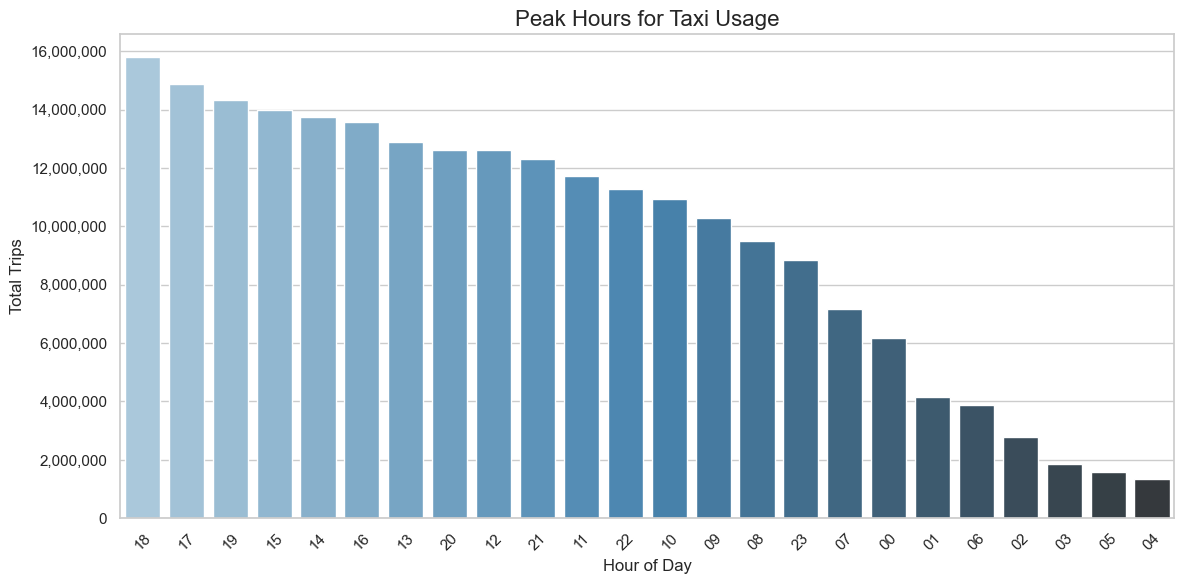

In [ ]:

plt.figure(figsize=(12, 6))
sns.barplot(x='pickup_hour', y='total_trips', data=peak_hours_df, palette="Blues_d")
plt.title('Peak Hours for Taxi Usage', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Total Trips', fontsize=12)
plt.xticks(rotation=45)

plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.tight_layout()
plt.savefig("visualizations/Peak_Hours_for_Taxi_Usage.svg", bbox_inches="tight", dpi=300)
plt.show()


In [11]:

# 2.How does passenger count affect the trip fare?

# Methode 1 without considering trip_distance

trip_fare_query_without_distance="""SELECT passenger_count, AVG(fare_amount) AS average_fare
    FROM trips
    GROUP BY passenger_count"""

trip_fare_without_distance_df= pd.read_sql_query(trip_fare_query_without_distance, sqlite3.connect(DB_FILE))




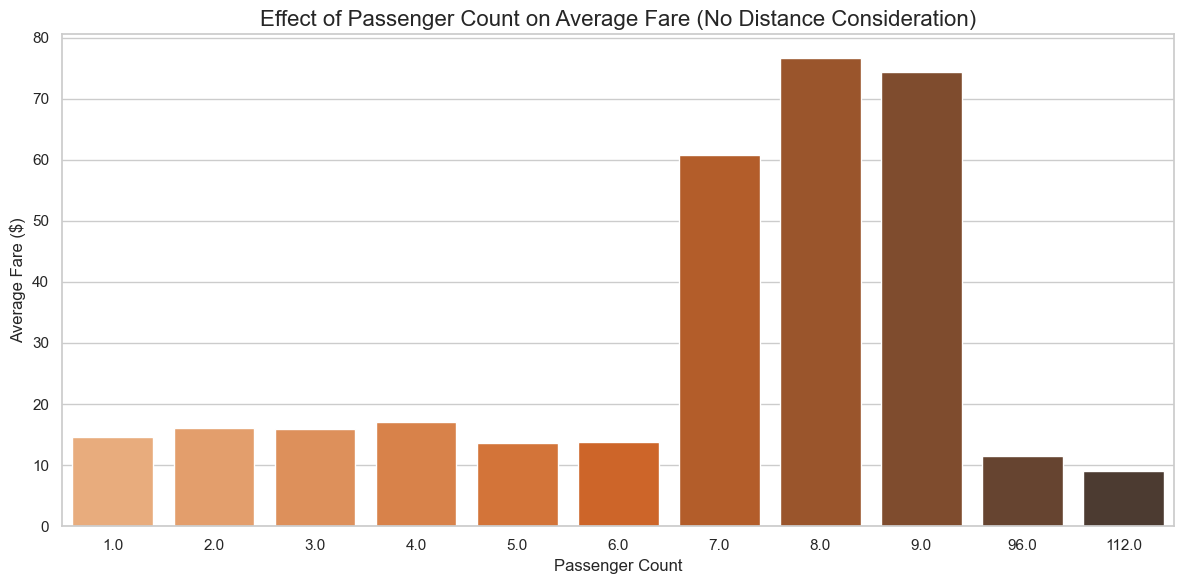

In [23]:
plt.figure(figsize=(12, 6))
sns.barplot(x='passenger_count', y='average_fare', data=trip_fare_without_distance_df, palette="Oranges_d")
plt.title('Effect of Passenger Count on Average Fare (No Distance Consideration)', fontsize=16)
plt.xlabel('Passenger Count', fontsize=12)
plt.ylabel('Average Fare ($)', fontsize=12)
plt.tight_layout()
plt.savefig("visualizations/Effect of Passenger Count on Average Fare (No Distance Consideration.svg", bbox_inches="tight", dpi=300)
plt.show()

In [13]:
# Methode 2 considering trip_distance

trip_fare_query_with_distance ="""SELECT
    passenger_count,
    CASE
        WHEN trip_distance < 2 THEN 'Short'
        WHEN trip_distance BETWEEN 2 AND 10 THEN 'Medium'
        ELSE 'Long'
    END AS distance_category,
    AVG(fare_amount) AS average_fare,
    AVG(fare_amount / trip_distance) AS average_fare_per_mile,
    COUNT(*) AS total_trips
FROM trips
WHERE trip_distance > 0 
AND fare_amount > 0 
and passenger_count >0 
GROUP BY passenger_count, distance_category
ORDER BY passenger_count, distance_category"""
trip_fare_with_distance_df= pd.read_sql_query(trip_fare_query_with_distance, sqlite3.connect(DB_FILE))

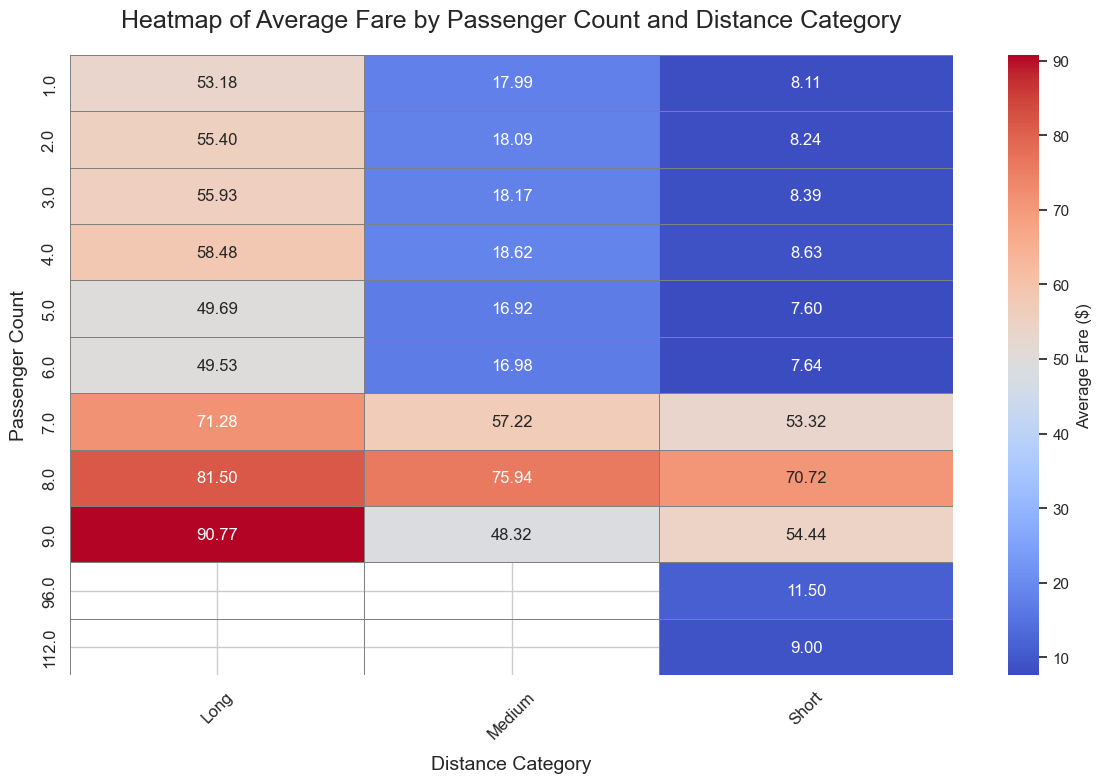

In [ ]:
plt.figure(figsize=(12, 8))


sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm", 
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={'label': 'Average Fare ($)', 'orientation': 'vertical'}
)


plt.title("Heatmap of Average Fare by Passenger Count and Distance Category", fontsize=18, pad=20)
plt.xlabel("Distance Category", fontsize=14, labelpad=10)
plt.ylabel("Passenger Count", fontsize=14, labelpad=10)

plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig("visualizations/Heatmap of Average Fare by Passenger Count and Distance Category.svg", bbox_inches="tight", dpi=300)

plt.show()


In [5]:
# 3.What are the trends in usage over the year?

yoy_usage_query="""select count(*) as total_trips,STRFTIME('%Y',tpep_pickup_datetime) as trip_year from trips t 
group by trip_year
order by trip_year"""

yoy_usage_df= pd.read_sql_query(yoy_usage_query, sqlite3.connect(DB_FILE))

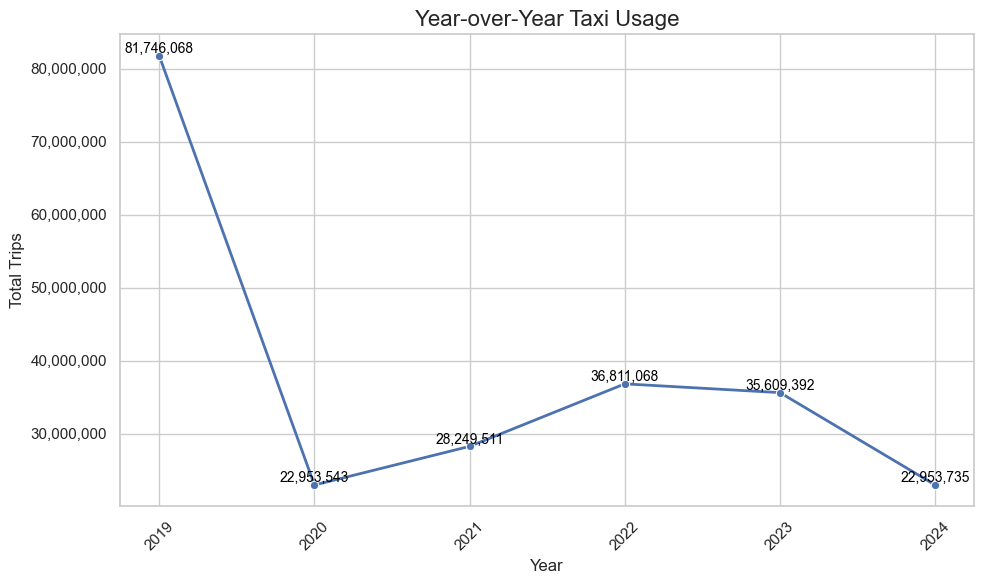

In [ ]:

plt.figure(figsize=(10, 6))
sns.lineplot(data=yoy_usage_df, x='trip_year', y='total_trips', marker='o', color='b', linewidth=2)
plt.title('Year-over-Year Taxi Usage', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Trips', fontsize=12)

# Format y-axis to show plain numbers with commas
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Add value annotations on each data point
for index, row in yoy_usage_df.iterrows():
    plt.text(row['trip_year'], row['total_trips'], f"{int(row['total_trips']):,}", 
             ha='center', va='bottom', fontsize=10, color='black')


plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("visualizations/YoY_Taxi_Usage_Line_Chart.svg", bbox_inches="tight", dpi=300)
plt.show()
